# Overview

Once a user is registered, there is always the possibility that a malicious actor will try to access that user's account.

Common mechanisms to deter illegitimate access include things like credentials (username and passwords) and multi-factor authentication.

Moonsense provides another layer of security – behavioral data that can be used for biometric authentication. This can be considered another form of multi-factor authentication, where attention is not centered on what the user knows (i.e., credentials) or what the user has (i.e., hardware token generators or mobile devices), but rather on __who the user is__. 

Every individual has a unique pattern to _how_ they interact with devices. 

In this demo, we'll examine individuals' key press patterns to discern legitimate from illegitimate users. We will focus primarily on statistical methods of analysis.

# Demo Design

(Note: this is an extension of the Registration ID Fraud demo and includes many similar elements.)

For the purpose of this demonstration, we asked a set of users to engage with a Moonsense demo environment.

One of the sections of the demo environment includes a sign in page.

The bottom left of the page includes a `Client Session Group` ID, which is a unique identifer for the given interaction.

The bottom left of the page reflects the version of the web SDK that has been deployed.

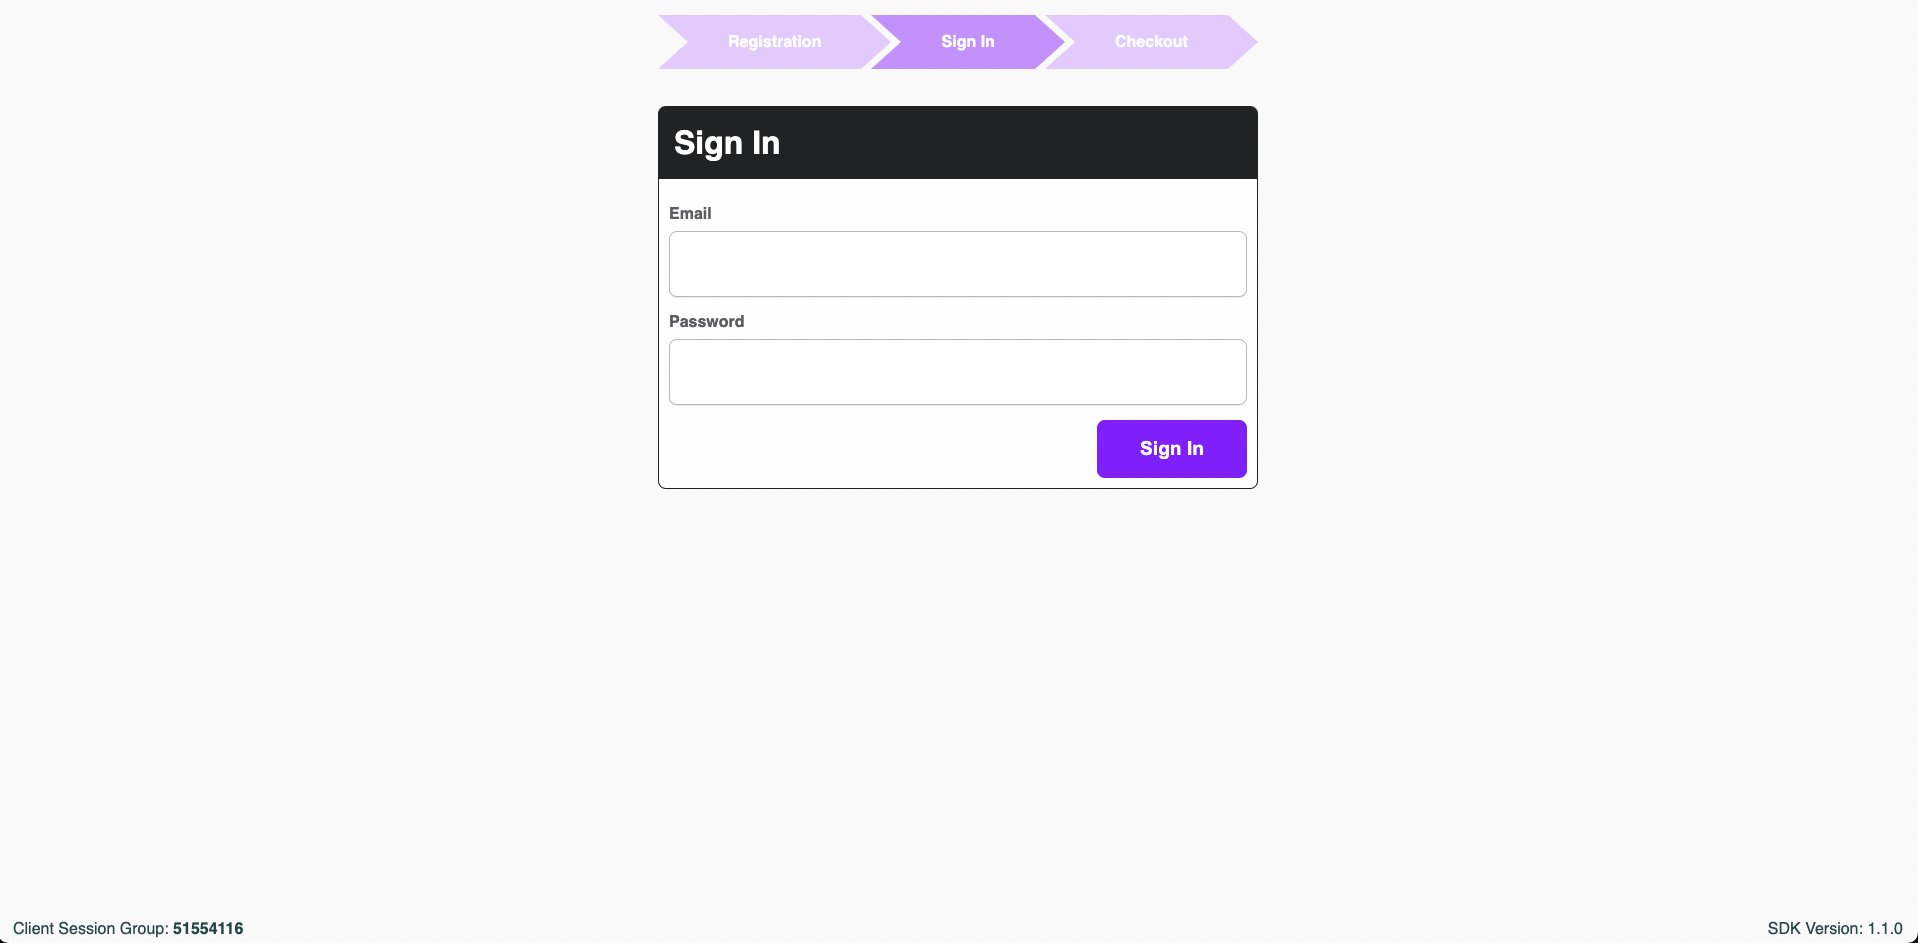

In this demo, we created a synthetic, balanced dataset.

Each user was asked to input their own legitimate email plus a provided password (i.e., not their own true password or an arbitrarily created one) a fixed number of times. They were then also asked to input a made up username and same provided password an equivalent number of times.

We asked the users to record the Client Session Group ID each time they completed the data collection exercise. Later on, we can use the Client Group Session ID as a way to tag the data collected as either `legitimate` or `illegitimate`. 

Below is a snippet of some synthetic data we asked our users to input, followed by the Client Session Group ID that the user input.

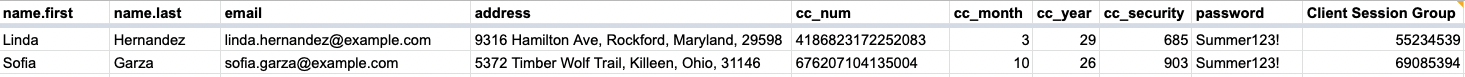

Once the input exercise was completed, we had a dataset made up of equal repetititions of legitimate and illegitimate repetitions.

To minimize environmental variabilty, we asked our users to only input details using a computer rather than with mobile devices.



# Setup
Before we proceed further, we'll load up some essential modules for this demo.

In [1]:
import pandas as pd # useful for data manipulation
import numpy as np # useful for numerical interaction
import scipy.stats as stats # useful for statistical analysis
import json # interact with .json files
import os # interact with the local operating system
import glob # enumerate files and directory structures
import csv # interact with .csv files
import seaborn as sns # visualization tooling
import matplotlib.pyplot as plt # visualization tooling

In [2]:
# suppress verbose warnings
import warnings
warnings.filterwarnings('ignore')

# Functions

Below are a collection of simple and explicit functions that facilitate interactions with the Moonsense data in this demo.

In [49]:
def get_raw_sealed_bundle_paths(data_path):
    """
    Given a top-level data path, this enumerates all the complete paths for the various raw_sealed_bundles.
    """
    total_path = data_path + "/**/raw_sealed_bundles.json"
    raw_sealed_bundles_paths = glob.glob(total_path, recursive=True)
    
    return raw_sealed_bundles_paths

In [50]:
def get_metadata_paths(data_path):
    """
    Given a top-level data path, this enumerates all the complete paths for the various metadata.json.
    """
    total_path = data_path + "/**/metadata.json"
    metadata_paths = glob.glob(total_path, recursive=True)
    
    return metadata_paths

In [51]:
def extract_gid(raw_sealed_bundles_path):
    """
    Based on the path, pull out the Client Session Group ID
    This works because the Client Session Group ID is part of the directory structure
    """
    gid = raw_sealed_bundles_path.split(os.sep)[4]
    
    return gid

In [52]:
def extract_sessionid(raw_sealed_bundles_path):
    """
    Based on the path, pull out the Session ID
    This works because the Session ID is part of the directory structure
    """
    sessionid = raw_sealed_bundles_path.split(os.sep)[3]
    
    return sessionid

In [53]:
def extract_target_sessionid(data_path, target):
    """
    Where 'target' is a label name.
    We're looking for sessions that contain a desired target. 
    Labels in the demo include: "sign-in", "registration", "payment", "checkout", "interaction", ...
    """
    sessions = []
    
    all_metadata_json = get_metadata_paths(data_path)
    
    for file in all_metadata_json:
        with open(file, 'r') as f:
            out = json.load(f)
    
            label_names = []
            for item in out['labels']:
                label_names.append(item['name'])

            if target in label_names:
                sessions.append(out['sessionId'])
                
    return(sessions)
        

In [54]:
def single_session(raw_sealed_bundles_path):
    """
    For each session, generate a two-dimensional dataframe with details specific to the 'key_press_data' collected.
    """

    gid = extract_gid(raw_sealed_bundles_path)
    
    json_list = []
    with open(raw_sealed_bundles_path, 'r') as f:
        for json_record in f:
            record_dict = json.loads(json_record)

            if "key_press_data" in record_dict['bundle']:
                json_list.append(record_dict['bundle']['key_press_data'])  
    
    df_agg = pd.DataFrame()
    
    for i in range(len(json_list)):
        df = pd.json_normalize(json_list[i])
        df_agg = df_agg.append(df)
    
    df_agg['gid'] = gid
    
    return df_agg

In [55]:
def multi_session(data_path, target = ""):
    """
    Given a top level data path, generate a consolidated dataframe of all key_press_data.
    Target is optional, it grabs specific sessions based on matching label names. if absent, grab everything.
    """
    
    # get all the paths of all the raw_sealed_bundles.json
    raw_paths = get_raw_sealed_bundle_paths(data_path)
    
    # target sessions
    if not target.strip():
        filtered_paths = raw_paths
    else:
        # take the raw path, filter it to session IDs that have targeted label names
        target_sessions = extract_target_sessionid(data_path, target)
        filtered_paths = [path for path in raw_paths if any(sessionid in path for sessionid in target_sessions)]
    
    df_multi = pd.DataFrame()
    
    for path in filtered_paths:
        df_single = single_session(path)
        df_multi = df_multi.append(df_single)
    
    return df_multi

# Data

__For this exercise, we'll focus primarily on key press data__, though there is plenty more Moonsense-sourced data to pick from.

To access the data en masse, first we'll have to generate a secret authentication token through the Moonsense console by navigating to `Apps`, selecting the appropriate App, and creating a token.

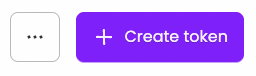

Once the token creation process is completed, a secret token and a public token will appear.


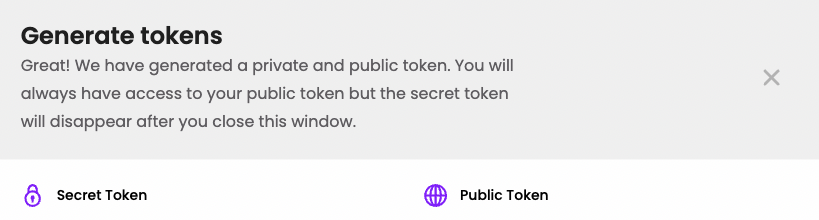

We recommend saving the tokens and then assigning the secret token to an environment variable.  The default token name that the Moonsense Python SDK searches for is called `MOONSENSE_SECRET_TOKEN`.

## Download

For convenience, we've provided a script `utils/download.py` that can programmatically download Moonsense data en masse.

It accepts three optional arguments, including:
* A start date
* An end date
* A .csv file with a `group_id` that will filter the returned data to only include data with matching `Client Session Group` IDs.

In our case, we executed the script with the following:

```bash
python3 utils/download.py --since 2022-08-03 --until 2022-08-06 --filter_by inputs/filtered_list.csv
```

Where `inputs/filtered_list.csv` is a .csv containg `Client Session Group` IDs.


Note that the script seeks out a `MOONSENSE_SECRET_TOKEN` environment variable for authentication purposes.

Successful execution of the script downloads a mass of data:

```bash
> tree data -l 3

data
├── 2022-08-04
│   └── 33643170
│       ├── eHZQczKU7Kcj57g586kZda
│       │   ├── metadata.json
│       │   └── raw_sealed_bundles.json
│       └── mdHAbnakubRW5NMdbii8g8
│           ├── metadata.json
│           └── raw_sealed_bundles.json
└── 2022-08-05
    ├── 06136989
    │   ├── B8qd5qLumW6c4NQs9zj9xY
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json
    │   ├── NUtMTn28SqVZSxbt2zFopN
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json
    │   ├── QJEknkpX6HhUCj2rq7eWp7
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json

...
```
The path structure is of the form: `./data/<date>/<Client Session Group>/<session>/*.json`

## Reshape data

The data in its raw form is rich, but it still needs to be reshaped for any given purpose.

In our case, our aim is to focus on keystroke dynamics, which is contained in `key_press_data` within the raw data. We are especially interested in the timing patterns of key presses. `key_press_data` appears across numerous `Session` records spread across different `raw_sealed_bundle.json` files.

Our goal is to generate a [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), flat dataframe that includes all available data related to the key presses – the timings, the time differences from key press event to another, the keys themselves, the user behind the keys, and more.

To utilize many of the functions we've prepared, first we'll define a variable with the top level data path.

In [56]:
# specify the path to the data, relative to the current notebook
top_data_path = "../../data/"

Next, we'll enumerate the full paths for all the `raw_sealed_bundles.json`.

In [57]:
raw_sealed_bundles = get_raw_sealed_bundle_paths(top_data_path)

In [58]:
# Preview a few records
raw_sealed_bundles[0:5]

['../../data/2022-08-04/33643170/eHZQczKU7Kcj57g586kZda/raw_sealed_bundles.json',
 '../../data/2022-08-04/33643170/mdHAbnakubRW5NMdbii8g8/raw_sealed_bundles.json',
 '../../data/2022-08-05/55234539/sw2iiW6f3aQ8JWubyRPKK7/raw_sealed_bundles.json',
 '../../data/2022-08-05/55234539/cFG2AY7xQG3m6ByAtWo2gc/raw_sealed_bundles.json',
 '../../data/2022-08-05/55234539/WEQjHuScQvsdwwZ94Yi3jD/raw_sealed_bundles.json']

This however grabs everything, including material that isn't strictly part of the sign-in page.

Each raw sealed bundle comes with a corresponding `metadata.json`, which provides a broad range of details, including _where_ the data originated from based on details contained within a `labels` key.

```bash
> tree data -l 3

data
├── 2022-08-04
│   └── 33643170
│       ├── eHZQczKU7Kcj57g586kZda
│       │   ├── metadata.json
│       │   └── raw_sealed_bundles.json
│       └── mdHAbnakubRW5NMdbii8g8
│           ├── metadata.json
│           └── raw_sealed_bundles.json
```

First, similar to the `raw_sealed_bundles.json`, we'll enumerate the `metadata.json` paths.

In [59]:
# get all the metadata paths
metadata_paths = get_metadata_paths(top_data_path)

In [60]:
metadata_paths[0:5]

['../../data/2022-08-04/33643170/eHZQczKU7Kcj57g586kZda/metadata.json',
 '../../data/2022-08-04/33643170/mdHAbnakubRW5NMdbii8g8/metadata.json',
 '../../data/2022-08-05/55234539/sw2iiW6f3aQ8JWubyRPKK7/metadata.json',
 '../../data/2022-08-05/55234539/cFG2AY7xQG3m6ByAtWo2gc/metadata.json',
 '../../data/2022-08-05/55234539/WEQjHuScQvsdwwZ94Yi3jD/metadata.json']

Let's inspect one of these up close.

In [61]:
with open(metadata_paths[0], 'r') as f:
    out = json.load(f)
    
    print(out)

{'sessionId': 'eHZQczKU7Kcj57g586kZda', 'appId': 'iznJpoSNZiub4WLaukazhQ', 'oldestEvent': '2022-08-04T18:20:04.394879570Z', 'newestEvent': '2022-08-04T18:23:56.843Z', 'createdAt': '2022-08-04T18:20:04.419039Z', 'metadata': {'platform': 'WEB', 'manufacturer': 'Chrome', 'model': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36', 'systemVersion': '103.0.0.0', 'isDevicePhysical': True, 'recordingProfile': {'name': 'fraud_and_risk', 'version': '1'}, 'releaseVersion': '0.7.1'}, 'counters': {'app_life_cycle': {'total': 4}, 'bundle': {'buckets': [{'startTime': '1659637380000', 'value': '5'}, {'startTime': '1659637260000', 'value': '3'}, {'startTime': '1659637200000', 'value': '11'}], 'total': 19}, 'custom_event': {'total': 1}, 'key_press': {'total': 2}, 'permission': {'total': 6}, 'pointer': {'total': 347}, 'viewport_size': {'total': 1}}, 'labels': [{'labelId': 'jyWrSmBNGYjiLZMDwh3jVH', 'name': 'registration'}, {'labelId': '

That's quite a bit of detail. Let's zoom in on the `labels` key.

In [62]:
out['labels']

[{'labelId': 'jyWrSmBNGYjiLZMDwh3jVH', 'name': 'registration'},
 {'labelId': 'tHgKseAziQjsK7NeDuSUA8', 'name': 'interaction'}]

That particular label indicates that the corresponding `raw_sealed_bundle.json` contains details associated with registration and interaction.

Since we're focused on sign-in in this particular example, let's hone in on a label name of "sign-in". The function we've written includes a parameter to specify a target to filter on.

In [104]:
sign_in_sessions = extract_target_sessionid(top_data_path, target="sign-in")

In [105]:
sign_in_sessions[0:10]

['WEQjHuScQvsdwwZ94Yi3jD',
 '2P4ZdB2WzQLabPHwKTVeEi',
 'M6TirUBEQmvaepSmKB7mUU',
 'RzH8LWriL2wpqWLxE3AK5e',
 '7QBUdTeS2cBEsbeG9cTwj5',
 'RfVUiVsbGaRgC4ZRmeHSiR',
 'zs6GD3JU77neAFLeTaPRmm',
 'FCb9ZxQqkU3hfuAqGCSt3j',
 'ESzYANnweFyMyXPFSxPP5E',
 'Peboyk6XxRwY4QXom7NCbZ']

Now we have the specific session IDs for sign-ins. We can use that to filter down the set of `raw_sealed_bundles.json` paths to only those that include sign-in data.

For demonstration purposes, let's look for only the first session ID that includes sign-in details, and return the full path.

In [65]:
target_path = [path for path in metadata_paths if sign_in_sessions[0] in path]

In [66]:
target_path[0]

'../../data/2022-08-05/55234539/WEQjHuScQvsdwwZ94Yi3jD/metadata.json'

In [67]:
with open(target_path[0], 'r') as f:
    out = json.load(f)

    print(out['labels'])

[{'labelId': 'FGM2exHL9tUeHYq96NGPJP', 'name': 'sign-in'}, {'labelId': 'HQWF72JoSgaasTWeawrqPD', 'name': 'sign-in'}, {'labelId': 'tHgKseAziQjsK7NeDuSUA8', 'name': 'interaction'}]


Note the presence of `'name': 'sign-in'`, indicating that this session includes data associated with sign-ins.

We'll use one of our defined functions to extract all the key press data associated with sessions that are linked to sign-ins.

In [68]:
filtered_df = multi_session(top_data_path, "sign-in")

In [69]:
filtered_df.head()

,determined_at,type,special_key,target.target_id,target.target_type,shift_key,masked_key,gid,meta_key
0,43994,KEY_UP,Enter,65cd98e7-9814-45c2-a30d-c667da9c35e4,body,NaN,NaN,55234539,NaN
0,47680,KEY_DOWN,Shift,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,NaN,55234539,NaN
1,47806,KEY_DOWN,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,7891.0,55234539,NaN
2,47898,KEY_UP,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,7891.0,55234539,NaN
3,47911,KEY_UP,Shift,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,NaN,55234539,NaN


In [70]:
len(filtered_df)

4305

In [71]:
filtered_df['type'].value_counts()

KEY_UP      2153
KEY_DOWN    2152
Name: type, dtype: int64

Before we go further, let's save this dataframe for easy access later.

In [72]:
filtered_df.to_csv("../processed-data/sign_in_key_press_data.csv", index=False)

In [73]:
filtered_df.dtypes

determined_at          object
type                   object
special_key            object
target.target_id       object
target.target_type     object
shift_key              object
masked_key            float64
gid                    object
meta_key               object
dtype: object

Next, we'll perform a number of data transformations to derived a desired feature - the time difference from one key down event to another.

In [74]:
# convert the 'determined_at' field to a numerical type so we can sort properly later
filtered_df['determined_at'] = filtered_df['determined_at'].astype(str).astype(int)

In [75]:
# filter to only include records with key down
key_press_filtered = filtered_df.loc[filtered_df['type']=='KEY_DOWN']

In [76]:
key_press_filtered.head()

,determined_at,type,special_key,target.target_id,target.target_type,shift_key,masked_key,gid,meta_key
0,47680,KEY_DOWN,Shift,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,NaN,55234539,NaN
1,47806,KEY_DOWN,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,7891.0,55234539,NaN
0,48035,KEY_DOWN,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,1075.0,55234539,NaN
2,48747,KEY_DOWN,Backspace,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,NaN,55234539,NaN
4,48886,KEY_DOWN,Backspace,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,NaN,55234539,NaN


In [77]:
# now we sort by the Client Session Group (i.e., individual user instance) and the time ordering, 'determined_at'
key_press_filtered = key_press_filtered.sort_values(by = ['gid', 'determined_at'], ascending = [True, True])

In [78]:
# Calculate the difference in time from one row to another, grouped by an individual instance
key_press_filtered['time_diff'] = key_press_filtered.groupby('gid')['determined_at'].diff()

In [79]:
key_press_filtered.head(10)

,determined_at,type,special_key,target.target_id,target.target_type,shift_key,masked_key,gid,meta_key,time_diff
0,36493,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,219.0,06136989,NaN,NaN
2,36753,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,216.0,06136989,NaN,260.0
3,36860,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,119.0,06136989,NaN,107.0
0,37032,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,83.0,06136989,NaN,172.0
2,37444,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,1020.0,06136989,NaN,412.0
4,37605,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,119.0,06136989,NaN,161.0
6,37758,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,120.0,06136989,NaN,153.0
0,38085,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,86.0,06136989,NaN,327.0
2,38459,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,1060.0,06136989,NaN,374.0
4,38588,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,214.0,06136989,NaN,129.0


In [80]:
key_press_filtered.tail(10)

,determined_at,type,special_key,target.target_id,target.target_type,shift_key,masked_key,gid,meta_key,time_diff
4,37348,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,7838.0,99564560,NaN,232.0
6,37580,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,1072.0,99564560,NaN,232.0
1,37724,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,1072.0,99564560,NaN,144.0
3,37852,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,585.0,99564560,NaN,128.0
4,37932,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,71.0,99564560,NaN,80.0
7,38164,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,105.0,99564560,NaN,232.0
8,38260,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,1033.0,99564560,NaN,96.0
11,38428,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,NaN,7925.0,99564560,NaN,168.0
0,38692,KEY_DOWN,Shift,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,True,NaN,99564560,NaN,264.0
1,38908,KEY_DOWN,NaN,c0c2999f-79c0-4617-9be3-e406ab38a13d,password,True,117.0,99564560,NaN,216.0


In [81]:
# let's save the prepared dataframe
key_press_filtered.to_csv("../processed-data/sign_in_key_down_diff.csv", index = False)

And there we have it! At this point, we have:

* Extracted the desired data, filtered to sign-in data focused on key presses
* Reshaped it into a dataframe containing all the source data
* Generated additional features out of that raw data

With that data, we can now start exploring the data to see if we can discern patterns that might suggest fraudulent sign-in attempts.

Next up, we'll go through the process of analyzing the data we've prepared so far.

# Analysis

For now, we'll focus on examining the time difference between key presses from key down to key down events. We'll approach this both visually and statistically.

## Prep Data

Before we proceed further, we'll first prepare the data by enriching it with some metadata that contains details on whether a given session is legitimate or illegitimate.

In [82]:
input_dat = pd.read_csv("../../inputs/synthetic-data-clean.csv")

In [83]:
# pad the Client Session Group so it's 8 digits long, prepended with 0 if needed.
input_dat['Client Session Group'] = input_dat['Client Session Group'].astype(str).str.zfill(8)

# create a 'legit' field to denote user journey legitimacy
input_dat['legit'] = np.where(input_dat['email'] == 'actual', True, False)

In [84]:
input_dat.head()

,index,user,name.first,name.last,email,address,cc_num,cc_month,cc_year,cc_security,password,Client Session Group,legit
0,1,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,47829696,True
1,7,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,75629502,True
2,13,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,62981988,True
3,19,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,99239641,True
4,25,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,95521006,True


In [85]:
# select specific fields
input_dat_sub = input_dat.loc[:, ['Client Session Group', 'legit', 'user']]

In [86]:
input_dat_sub.head()

,Client Session Group,legit,user
0,47829696,True,Arnold
1,75629502,True,Arnold
2,62981988,True,Arnold
3,99239641,True,Arnold
4,95521006,True,Arnold


We'll enrich `key_press_filtered` by joining on the `Client Session Group`/`gid` fields.

In [87]:
df = key_press_filtered.merge(input_dat_sub, left_on='gid', right_on='Client Session Group', how='left')

In [88]:
df.head()

,determined_at,type,special_key,target.target_id,target.target_type,shift_key,masked_key,gid,meta_key,time_diff,Client Session Group,legit,user
0,36493,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,219.0,06136989,NaN,NaN,06136989,False,Bernard
1,36753,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,216.0,06136989,NaN,260.0,06136989,False,Bernard
2,36860,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,119.0,06136989,NaN,107.0,06136989,False,Bernard
3,37032,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,83.0,06136989,NaN,172.0,06136989,False,Bernard
4,37444,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,1020.0,06136989,NaN,412.0,06136989,False,Bernard


In [89]:
df['legit'].value_counts()

False    1160
True      992
Name: legit, dtype: int64

## Statistical Analysis

In the current context, we are trying to determine if two different categories – legitimate and illegitimate – are statistically different from each other to a significant degree.

We can apply a statistical test to determine if there is a statistically significant difference between the two groups, where we can state the null hypothesis and alternative hypothesis as follows:

* __Null hypothesis__: there is _not_ a statistically significant difference between the two groups

* __Alternative hypothesis__: the observed difference is statistically significant to a degree to suggest that the two groups are in fact different.

The sign-in page requires two inputs: an email and a password. In the original data collection, we asked users to input an equal number of legitimate emails (i.e., their own actual work emails) and illegitimate emails (i.e., synthetically generated emails that users would not be familiar with). The password we asked users to input in all cases was a fairly simple consistent password. After a few iterations, we expected the users to develop a high degree of familiarity with the password. 

Let's take a look at the four groups of data:
* Legitimate password
* Legitimate email
* Illegitimate password
* Illegitimate email

In [91]:
# define some standard colors
ms_orange = "#FF9E01"
ms_purple = "#882CFF"

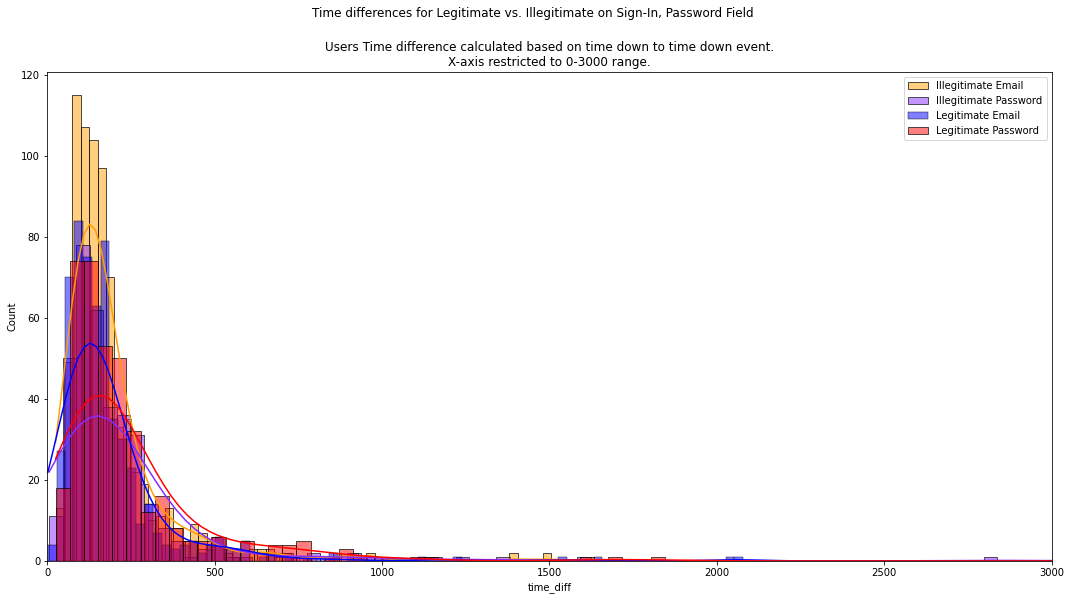

In [93]:
sns.histplot(data=df.loc[(df['legit'] == False) & (df['target.target_type'] == "email")], x="time_diff", color=ms_orange, label="Illegitimate Email", kde=True)
sns.histplot(data=df.loc[(df['legit'] == False) & (df['target.target_type'] == "password")], x="time_diff", color=ms_purple, label="Illegitimate Password", kde=True)
sns.histplot(data=df.loc[(df['legit'] == True) & (df['target.target_type'] == "email")], x="time_diff", color="blue", label="Legitimate Email", kde=True)
sns.histplot(data=df.loc[(df['legit'] == True) & (df['target.target_type'] == "password")], x="time_diff", color="red", label="Legitimate Password", kde=True)

plt.legend() 
plt.suptitle('Time differences for Legitimate vs. Illegitimate on Sign-In, Password Field')
plt.title('Users Time difference calculated based on time down to time down event.\nX-axis restricted to 0-3000 range.')
plt.xlim([0,3000])
plt.rcParams["figure.figsize"] = (18, 9)
plt.show()

Visually, it does appear that there are notably higher concentrations for particular input times for illegitimate emails, though this is not a very robust conclusion.

We can turn to statistical testing to arrive at more robust conclusions.

For the purpose of this statistical analysis, we can frame the unit of observation as the difference between the mean time differences between key down to key down events for the email fields and the mean time differences between key down to key down events for the password field.

__Why are we framing it as such?__ Well, we can assume that there can be a lot of stochasticity (i.e., variation) with typing in fields, with broad variation appearing across sessions and users. However, because the password input values are consistent, the typing cadence related to the password in effect establishes a baseline for what familiar typing is like for users.

In effect, with this sort of difference of means framing, we are effectively asking, __"How different is the typing cadence for the email field (where the emails can be either familiar or unfamiliar) compared to the password field (the baseline for familiarity)?"__ 

If there is a notable difference in cadence due to the lack of familiarity with certain emails, that would hopefully manifest in the data.


First, we'll calculate the difference between the mean time differences for email and password within each `Group Client Session`.

In [94]:
df_pivot = df.loc[:, ['Client Session Group', 'target.target_type', 'legit', 'user', 'time_diff']] \
    .dropna() \
    .groupby(['Client Session Group', 'target.target_type']).mean('time_diff') \
    .reset_index() \
    .pivot(index=["Client Session Group", "legit"], columns = "target.target_type", values="time_diff") \
    .reset_index()

df_pivot['mean_diff'] = df_pivot['email'] - df_pivot['password']

In [95]:
len(df_pivot)

57

In [96]:
df_pivot.head()

target.target_type,Client Session Group,legit,email,password,submit,mean_diff
0,06136989,0.0,172.500000,184.666667,NaN,-12.166667
1,06455365,1.0,138.473684,224.923077,NaN,-86.449393
2,07361069,0.0,259.032258,192.461538,NaN,66.570720
3,07937433,0.0,149.925926,177.333333,NaN,-27.407407
4,08215655,1.0,204.631579,191.692308,NaN,12.939271


In [97]:
# calculate the mean of the difference between legitimate and illegitimate cases
df_pivot.groupby('legit').mean()

target.target_type,email,password,submit,mean_diff
legit,,,,
0.0,198.041461,235.925685,229.0,-37.884224
1.0,188.461505,263.837948,175.0,-75.376443


In [98]:
# calculate the standard deviation of the difference between legitimate and illegitimate cases
df_pivot.groupby('legit').std()

target.target_type,email,password,submit,mean_diff
legit,,,,
0.0,39.272642,101.840033,0.0,98.498433
1.0,73.370786,91.887222,NaN,124.483157


Let's inspect the two groups of calculated means visually first.

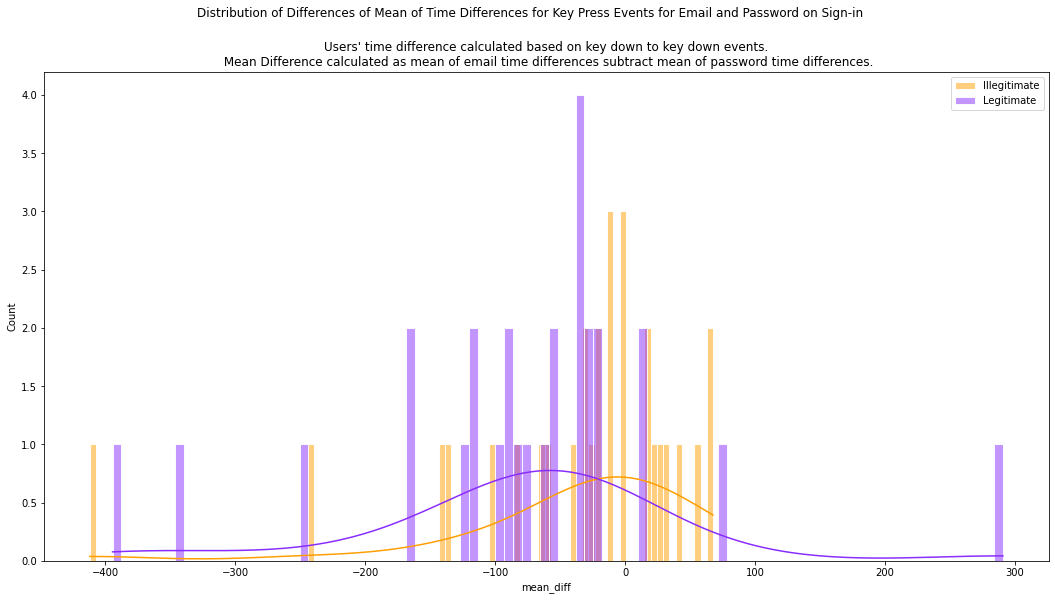

In [99]:
bins_num = 100
edgecolor_spec ="white"

sns.histplot(data=df_pivot.loc[df_pivot['legit'] == 0.0], x="mean_diff", color=ms_orange, edgecolor = edgecolor_spec, bins = bins_num, label="Illegitimate", kde=True)
sns.histplot(data=df_pivot.loc[df_pivot['legit'] == 1.0], x="mean_diff", color=ms_purple, edgecolor = edgecolor_spec, bins = bins_num, label="Legitimate", kde=True)

# plt.hist(data=df_pivot.loc[df_pivot['legit'] == 0.0], x="mean_diff", color=ms_orange, bins = bins_num, label="Illegitimate")
# plt.hist(data=df_pivot.loc[df_pivot['legit'] == 1.0], x="mean_diff", color=ms_purple, bins = bins_num, label="Legitimate")


plt.legend() 
plt.suptitle('Distribution of Differences of Mean of Time Differences for Key Press Events for Email and Password on Sign-in')
plt.title('Users\' time difference calculated based on key down to key down events.\n Mean Difference calculated as mean of email time differences subtract mean of password time differences.')
# plt.xlim([0,500])
plt.rcParams["figure.figsize"] = (16, 9)
plt.show()

The plot suggests that the data is skewed and not perfectly normal. Were the two groups normal, a viable statistical test would be a two samples T-test of means.

To account for skew, we can instead try a Mann-Whitney U-Test, which instead of performing a statistical comparison based on means, is based on ranked sums instead. The Mann-Whitney test is robust to lack of normalcy in the distribution, skewness, outliers, and differences in variances.

To perform the Mann-Whitney U-Test, we'll first have to create two separate Numpy arrays, one for the illegitimate set, and another for the legitimate set.

In [108]:
illegit_pivot = df_pivot.loc[df_pivot['legit'] == 0.0, ['mean_diff']]

array_illegit_pivot = illegit_pivot['mean_diff'].to_numpy()

array_illegit_pivot

array([ -12.16666667,   66.5707196 ,  -27.40740741,   67.61538462,
         16.96615385,  -39.94314381,   42.25641026, -411.66666667,
       -104.        ,  -29.63076923, -139.52727273,   17.86666667,
         -0.96153846,  -82.        ,   28.45833333, -137.45920746,
        -59.72934473,  -30.07407407,  -64.49358974, -240.26098901,
        -10.04923077,   55.87384615,  -21.96153846,  -11.        ,
         -3.30434783,   32.82666667,   24.10576923,  -21.28      ,
         -4.26666667])

In [109]:
legit_pivot = df_pivot.loc[df_pivot['legit'] == 1.0, ['mean_diff']]

array_legit_pivot = legit_pivot['mean_diff'].to_numpy()

array_legit_pivot

array([ -86.44939271,   12.93927126,  -31.92307692,  -35.36842105,
         16.64102564,  290.65345528,  -37.62745098,  -25.55      ,
        -92.        ,  -17.8245614 , -166.06020067, -162.1025641 ,
        -23.06666667,  -85.98333333, -118.        , -345.26923077,
         77.04511278, -125.22727273,  -73.78947368, -244.18681319,
        -31.40350877,  -54.22222222,  -25.05769231,  -98.78076923,
        -52.42105263, -394.2       , -117.75      ,  -63.55555556])

Now that we have the arrays, we are now able to perform the stastical test. Because our framing of the question is merely to seek out a difference between the two groups, we are in effect performing a two-sided test.

In [102]:
mwtest_results = stats.mannwhitneyu(x=array_legit_pivot, y=array_illegit_pivot, alternative = 'two-sided')

In [103]:
mwtest_results

MannwhitneyuResult(statistic=252.0, pvalue=0.014276467877997584)

The observed P-value is quite small, under the typical 5% threshold.

Based on this result, we can conclude that there is a stastically significant difference between the typing cadence for legitimate cases and illegitimate cases. The likelihood of the observed outcome appearing due solely to chance statistical sampling rather than true attributes of the populations is improbable.

# Conclusion

In this demonstration, we went through an exercise of:
* Bulk-downloading data collected through Moonsense
* Filtering, transforming, and enriching that data
* Framing the data based on our understanding of _how_ the data was collected
* Performing a statistical analysis to determine if there is a quantifiable difference between legitimate and illegitimate cases, using a test that accounted for the underlying shape of the data

We ultimately concluded that there is in fact a statistically significant difference in typing cadence between legitimate and illegitimate cases based on the current observed sample.

There are other avenues to purpose to expand on this analysis, including:
* Collecting a broader sample
* Incorporating other features available through the Moonsense data collection